# Importing the libraries.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#  Next Important step is Data Transformation.

#### We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

### Here is the list of all the transformations which come pre-built with PyTorch

#### Compose
#### ToTensor
#### ToPILImage
#### Normalize
#### Resize
#### Scale
#### CenterCrop
#### Pad
#### Lambda
#### RandomApply
#### RandomChoice
#### RandomOrder
#### RandomCrop
#### RandomHorizontalFlip
#### RandomVerticalFlip
#### RandomResizedCrop
#### RandomSizedCrop
#### FiveCrop
#### TenCrop
#### LinearTransformation
#### ColorJitter
#### RandomRotation
#### RandomAffine
#### Grayscale
#### RandomGrayscale
#### RandomPerspective
#### RandomErasing

## Transforming our data

### Now we will be normalizing our data and also will be converting our data into tensors hence first find out the mean and standard deviation of our data because those are the numbers we will need to supply in the Normalize function.

In [2]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\Users\RASHU TYAGI\AppData\Roaming\Python\Python37\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Mean = 0.1307 and Standard Deviation = 0.3081

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(), # converting the images to tensors 
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1 # so that we get same random sample everytime.

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility --> so that we get same random sample everytime.
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics - They describe the overall data.

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


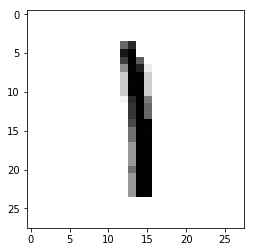

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[3].numpy().squeeze(), cmap='gray_r')


## It is important that we view as many images as possible. This is required to get some idea on image augmentation later on.

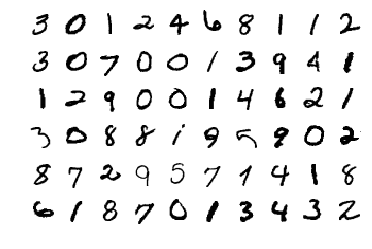

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26*26*16

        # CONVOLUTION BLOCK 1
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24*24*10
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22*22*16

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11*11*20
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11*11*10  # 1*1 convolution does not effect the size of the image

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9*9*10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 7*7*16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7*7*10
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER use Batch Normalization on the output of last layer.
            # nn.ReLU() NEVER! Use Relu on the last layer.
        ) # output_size = 1*1*1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## It is important to view the model summary and the model parameters and as there is not inbuilt function hence we do it using the following code

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,440
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             160
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

### So we can see that we have  10,760 parameters which is less and thats good for our model lets try for the accuracy.


## What we have basically done to make our model lighter is that we did not make the number of channels to be very large in any of the layers which kept the number of parameters to be less throughout.

# Train and Test Functions.

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)  #nll means negative log loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.039966028183698654 Batch_id=468 Accuracy=94.56: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.07it/s]



Test set: Average loss: 0.0516, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.019332563504576683 Batch_id=468 Accuracy=98.45: 100%|█████████████████████████| 469/469 [00:07<00:00, 58.70it/s]



Test set: Average loss: 0.0436, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.0040606060065329075 Batch_id=468 Accuracy=98.81: 100%|████████████████████████| 469/469 [00:07<00:00, 60.06it/s]



Test set: Average loss: 0.0382, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.01886098086833954 Batch_id=468 Accuracy=99.06: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.43it/s]



Test set: Average loss: 0.0287, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.01533690094947815 Batch_id=468 Accuracy=99.22: 100%|██████████████████████████| 469/469 [00:07<00:00, 59.54it/s]



Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.007282128091901541 Batch_id=468 Accuracy=99.28: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.98it/s]



Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.01476516854017973 Batch_id=468 Accuracy=99.35: 100%|██████████████████████████| 469/469 [00:07<00:00, 59.10it/s]



Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.006780555006116629 Batch_id=468 Accuracy=99.42: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.48it/s]



Test set: Average loss: 0.0337, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.21698875725269318 Batch_id=468 Accuracy=99.47: 100%|██████████████████████████| 469/469 [00:07<00:00, 61.01it/s]



Test set: Average loss: 0.0280, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.00362897920422256 Batch_id=468 Accuracy=99.56: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.67it/s]



Test set: Average loss: 0.0259, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.010984485037624836 Batch_id=468 Accuracy=99.58: 100%|█████████████████████████| 469/469 [00:07<00:00, 61.06it/s]



Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.007872149348258972 Batch_id=468 Accuracy=99.64: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.98it/s]



Test set: Average loss: 0.0254, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.008656988851726055 Batch_id=468 Accuracy=99.69: 100%|█████████████████████████| 469/469 [00:07<00:00, 79.88it/s]



Test set: Average loss: 0.0263, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.0024518370628356934 Batch_id=468 Accuracy=99.75: 100%|████████████████████████| 469/469 [00:07<00:00, 60.78it/s]



Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.0012680292129516602 Batch_id=468 Accuracy=99.73: 100%|████████████████████████| 469/469 [00:07<00:00, 60.26it/s]



Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.0012146135559305549 Batch_id=468 Accuracy=99.77: 100%|████████████████████████| 469/469 [00:07<00:00, 60.98it/s]



Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)

EPOCH: 16


Loss=0.007232984062284231 Batch_id=468 Accuracy=99.83: 100%|█████████████████████████| 469/469 [00:07<00:00, 61.09it/s]



Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.01867567002773285 Batch_id=468 Accuracy=99.81: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.77it/s]



Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.006450265645980835 Batch_id=468 Accuracy=99.87: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.53it/s]



Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.0029794771689921618 Batch_id=468 Accuracy=99.90: 100%|████████████████████████| 469/469 [00:07<00:00, 61.43it/s]



Test set: Average loss: 0.0296, Accuracy: 9908/10000 (99.08%)



# Results :-

### 1.) Best Training Accuracy: 99.90%
### 2.) Best Test Accuracy : 99.25%
### 3.) Number of parameters : 10,760

### Number of parameters are too less here and also our model is performing good on these parameters also.But There is  overfitting in the model as we can see the gap between train and test accuracy is very high this time. And the train accuracy cannot  be pushed a little furthur to make our test accuracy reach upto 99.4%.

## In order to remove overfitting we use Regularisation techniques.

### Switch to Round 5 where we try to make furthur improvements.